In [0]:
import os
import os.path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import csv
import sys
import errno
import ntpath

from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy.io.wavfile import write as wav_write
import librosa
import librosa.display
import scikits.samplerate
from pydub.silence import split_on_silence

%matplotlib inline

In [0]:
# create csv file to append the mfccs calculated for each audio sample
with open('mfccs_dev.csv', 'w') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    # header
    #filewriter.writerow(['filename', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_mean', 'delta_mfcc', 'delta2_mfcc'])
    filewriter.writerow(['filename', 'mfcc_mean1', 'mfcc_mean2', 'mfcc_mean3', 'mfcc_mean4', 'mfcc_mean5', 'mfcc_mean6', 'mfcc_mean7', 'mfcc_mean8', 'mfcc_mean9', 'mfcc_mean10', 'mfcc_mean11', 'mfcc_mean12', 'mfcc_mean13'])

In [0]:
# get filename from a path
def get_filename(path):
    head, tail = ntpath.split(path)
    tail= tail.split(".")[0]
    return tail or ntpath.basename(head)

In [0]:
# plot audio file wave form
def audio_plot(audiofile, SAMPLE_RATE, duration, input_dir, savedir):
    y, sr = librosa.load(audiofile, sr = SAMPLE_RATE, duration = duration)
    filename = get_filename(audiofile)

    plt.figure(figsize=(14,4))
    plt.figure()
    plt.title("Audio sample at {} for {} ({} of {}) ".format(SAMPLE_RATE, filename, i, len(os.listdir(input_dir))))
    librosa.display.waveplot(y, sr = sr)
    plt.grid
    plt.savefig(savedir + 'audio_at_{}_{}.png'.format(SAMPLE_RATE,filename))
    return y, sr

In [0]:
# read in wav audiofile 
# return signal as np array and sampling rate as int
def read_audio(audiofile):
    sampling_rate, sig = wav.read(audiofile)
    return sig, sampling_rate

In [0]:
# chunk up audio into separate words
# audio is silent if quiter than a threshold of -16 dBFS
# whenever this threshold is met in the audio, we assume the word ended
# and start another word audio when the threshold is exceeded again

def word_chunk(audiofile):
  # min silence length betn words = 100ms = 0.1s
  # define silence as 16 db quieter than average loudness 
  # don't leave silence at start and end of word chunk

    savedir = 'word_chunk/'
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    
    filename = get_filename(audiofile)
    chunks = split_on_silence(audiofile, min_silence_len=100, silence_thresh=-16);

  # chunks is the original audio with all words zipped
  # to export separate words
    for i, chunk in enumerate(chunks):
    # output files are chunk0.wav, ..., chunk#.wav
        chunk.export(savedir+'{}_chunk{}.wav'.format(filename, i), format="wav")

In [0]:
# MFCC (Mel Frequency Cepstral Coefficients)
# MFCC decorrelates features
# Using Librosa python package
def mfcc_deltas(sample_rate, mfcc, input_dir, audiofile, i):
  # pad first and second deltas
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    savedir = 'mfcc_deltas/'
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    
    filename = get_filename(audiofile)

  # Visualization
    plt.figure(figsize=(12,4))

    plt.subplot(3,1,1)
    librosa.display.specshow(mfcc)
    plt.title("MFCC for {} ({} of {}) ".format(filename, i, len(os.listdir(input_dir))))
    plt.ylabel("MFCC")
    plt.colorbar()

    plt.subplot(3,1,2)
    librosa.display.specshow(delta_mfcc)
    plt.ylabel("MFCC-$\Delta$")
    plt.colorbar()

    plt.subplot(3,1,3)
    librosa.display.specshow(delta2_mfcc, sr=sample_rate, x_axis="time")
    plt.ylabel("MFCC-$\Delta^2$")
    plt.xlabel("Time")
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(savedir + 'MFCC_{}_{}.png'.format(SAMPLE_RATE,filename))

    return delta_mfcc, delta2_mfcc

AttributeError: 'str' object has no attribute 'export'

<Figure size 1008x288 with 0 Axes>

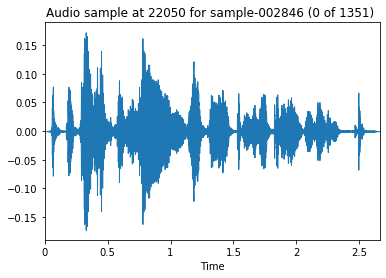

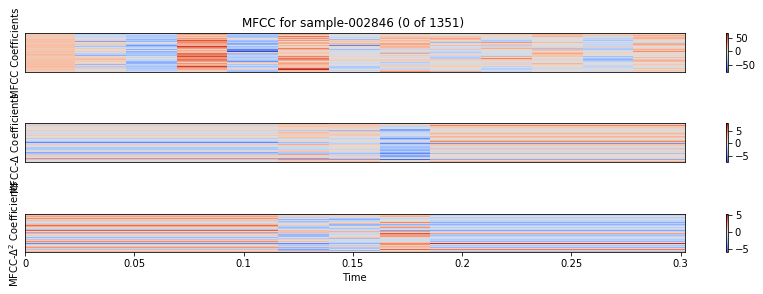

In [0]:
datadir = 'cv-valid-dev-wav' #Insert folder path of the audio dataset

for i, audiofile in enumerate(os.listdir(datadir)):
    if audiofile.endswith('.wav'):
        # Insert directory you'd like to save in
        savedir = 'preprocessed/'
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        
        filename = get_filename(audiofile)
        #audio = AudioSegment.from_mp3(audiofile)
        #audio.export()

        # Audible sound to a human is 22050 Hz (22 KHz)
        SAMPLE_RATE = 22050   #16000 Hz (16 KHz)
        # chop at 5 seconds so the differences in the plots are more perceptible and consistent
        duration = 5 #try with and without and save in separate directories

        # uncomment if files haven't been converted from mp3 to wav
        # audio = AudioSegment.from_mp3(src)
        # audio.export(dst, format = "wav")
        
        path_file = os.path.join(datadir,audiofile)
        
        y, sr = audio_plot(path_file, SAMPLE_RATE, duration, datadir, savedir)

        sig, sampling_rate = read_audio(path_file)

        # using librosa
        # extract top 13 mfcc coefficients
        # returns M:np.ndarray [shape=(n_mfcc, t)] MFCC sequence
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # using python speaking features
        mfcc_coef = mfcc(sig, sampling_rate)
        # get mean mfcc
        mfcc_mean = np.mean(mfcc_coef, axis = 0)
        # mfcc deltas
        delta_mfcc, delta2_mfcc = mfcc_deltas(SAMPLE_RATE, mfcc_coef, datadir, path_file, i)
        # write into mfcc csv file
        with open('mfccs_dev.csv', 'a') as csvfile:
            filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
            filewriter.writerow([filename, mfcc_mean[0], mfcc_mean[1], mfcc_mean[2], mfcc_mean[3], mfcc_mean[4], mfcc_mean[5], mfcc_mean[6], mfcc_mean[7], mfcc_mean[8], mfcc_mean[9], mfcc_mean[10], mfcc_mean[11], mfcc_mean[12]])
        # chunk up audio into separate words
        #word_chunk(audiofile)


In [0]:
path="cv-valid-dev-wav/sample-002846.wav"
head, tail = ntpath.split(path)

print(head)
print(tail.split(".")[0])
print(ntpath.basename(head))

cv-valid-dev-wav
sample-002846
cv-valid-dev-wav


In [0]:
savedir = 'mfcc_deltas/'
os.mkdir(savedir)